In [5]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

In [6]:
import os.path
from itertools import chain, combinations
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from gapstatistics.gapstatistics import GapStatistics
from clustering import AgglomerativeClusteringWrapper as AgglomerativeClustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import jensenshannon, correlation, euclidean
from tqdm.contrib.concurrent import thread_map

import config

In [7]:
config.INFERENCE_MODE_EXPLAINING_FEATURES

'exact'

In [8]:
#ClusteringApplier.calculate_explainable_distances()

In [9]:
df_explainable: pd.DataFrame = ClusteringApplier.read_explaining_features() # removed [list(config.EXPLAINING_FEATURE_NAMES.keys())]
df_observable_distances: pd.DataFrame = pd.read_excel(
    f"{config.OUTPUT_FOLDER_BASE}observables/{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_col=0
)
features: List[str] = list(config.EXPLAINING_FEATURE_NAMES.keys())

In [10]:
#df_explainable#.set_index(df_explainable.columns[0], inplace=True)
#df_observable_distances#.set_index(df_observable_distances.columns[0], inplace=True)

In [11]:
valid_indices = np.intersect1d(df_explainable.index, df_observable_distances.index)

df_explainable = df_explainable.loc[valid_indices]
df_observable_distances = df_observable_distances.loc[valid_indices]

In [12]:
def calculate_pairwise_distances_alt(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))

        for grp_i in range(df.shape[0]):
            for grp_j in range(df.shape[0]):      
                fingerprint_1 = df.iloc[grp_i][feature_names].to_numpy()
                fingerprint_2 = df.iloc[grp_j][feature_names].to_numpy()
                if distance == "jensenshannon":
                    dist: float = 1.0 * jensenshannon(fingerprint_1, fingerprint_2)
                elif distance == "correlation":
                    dist = 1.0 * correlation(fingerprint_1, fingerprint_2)
                else:
                    dist = 1.0 * euclidean(fingerprint_1, fingerprint_2)
                distance_matrix[grp_i, grp_j] = dist

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))
        arr = df.loc[:, feature_names].to_numpy()

        for grp_i in range(df.shape[0]):
            for grp_j in range(df.shape[0]):      
                fingerprint_1 = arr[grp_i]
                fingerprint_2 = arr[grp_j]
                if distance == "jensenshannon":
                    dist: float = 1.0 * jensenshannon(fingerprint_1, fingerprint_2)
                elif distance == "correlation":
                    dist = 1.0 * correlation(fingerprint_1, fingerprint_2)
                else:
                    dist = 1.0 * euclidean(fingerprint_1, fingerprint_2)
                distance_matrix[grp_i, grp_j] = dist

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

def calculate_pairwise_distances2(
        df: pd.DataFrame, feature_names: List[str], distance: str,
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

        if distance not in [
            "jensenshannon",
            "euclidean",
            "correlation",
        ]:
            raise Exception(
                "Invalid distance measure used to measure similarity."
            )

        distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))
        fingerprint_df = df.loc[:, feature_names]
        fingerprint_array = fingerprint_df.to_numpy()

        if distance == "jensenshannon":
            dist = lambda u,v: 1.0 * jensenshannon(u,v)
        elif distance == "correlation":
            dist = lambda u,v: 1.0 * correlation(u,v)
        else:
            dist = lambda u,v: 1.0 * euclidean(u,v) 

        for i in range(df.shape[0]):
            other_fingerprint = fingerprint_array[i]   
            distance_matrix[:, i] = np.apply_along_axis(
                 func1d=dist, axis=1, arr=fingerprint_array, v=other_fingerprint)

        normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

        return pd.DataFrame(
            distance_matrix, columns=df.index, index=df.index
        ), pd.DataFrame(
            normalised_distance_matrix, columns=df.index, index=df.index, 
        )

In [13]:
df = df_explainable

In [14]:
import seaborn as sns

In [15]:
'''optimal_feature_set, maximum_correlation = (
    ClusteringApplier._feature_selection_exhaustive(
        df_explainable, df_observable_distances, features
    )
)'''

powerset_features = chain.from_iterable(
    combinations(features, r) for r in range(2, len(features) + 1)
)
powerset_method_input = [
    (list(feature_set), df_explainable, df_observable_distances)
    for feature_set in powerset_features
]
correlation_coefficients: List[float] = thread_map(
    ClusteringApplier._get_correlation_coefficient,
    powerset_method_input,
    max_workers=config.MAX_NUM_THREADS,
)

  0%|          | 0/1013 [00:00<?, ?it/s]

In [17]:
maximum_correlation: float = max(correlation_coefficients)
optimal_feature_set: List[str] = features
current_feature_size = len(features)

In [18]:
for index in range(len(correlation_coefficients)):
    if correlation_coefficients[index] == maximum_correlation:
        current_feature_set = powerset_method_input[index][0]
        if len(current_feature_set) < current_feature_size:
            current_feature_size = len(current_feature_set)
            optimal_feature_set = current_feature_set

<Axes: ylabel='Count'>

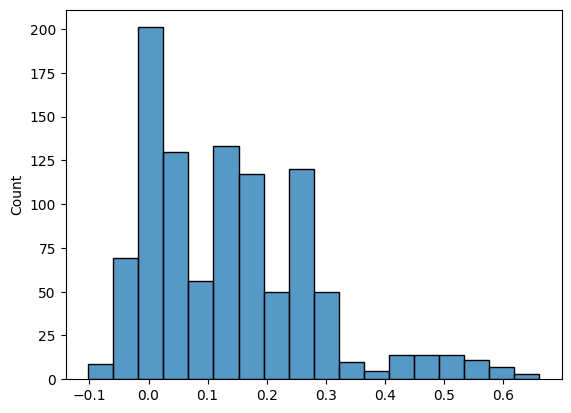

In [19]:
sns.histplot(correlation_coefficients)

In [45]:
optimal_feature_set

['Family_ID', 'Order_ID']

In [23]:
# Def 5.

df_explainable

,Age,Sex,Zoo,Stable,Genus_ID,Family_ID,Order_ID,SH,Weight,Habitat
Individual,,,,,,,,,,
A.nas_01,0.999747,0.002341,0.099694,0.998840,0.169083,0.999551,0.499767,0.601464,0.041510,0.999681
A.nas_02,1.001306,1.000698,0.101274,0.000311,0.171466,0.999230,0.498396,0.600267,0.040525,1.000003
A.nas_03,0.999255,0.999968,0.099513,0.000711,0.174282,0.999651,0.500578,0.599855,0.040196,1.000547
A.nas_05,1.002021,0.999557,0.451949,0.998960,0.168951,0.998391,0.499439,0.599631,0.038517,1.000423
A.nas_06,1.001024,0.998515,0.449397,0.999903,0.170082,1.001279,0.499827,0.601195,0.042261,0.999958
...,...,...,...,...,...,...,...,...,...,...
T.spe_01,1.000840,-0.000621,0.547933,0.999775,0.384676,0.999853,0.500246,0.518877,0.032690,0.001027
T.str_01,0.999244,0.000095,0.500510,1.000803,0.383518,0.999625,0.499688,0.791647,0.109674,0.334176
T.str_02,0.999667,0.001185,0.599788,0.999715,0.383644,0.998846,0.499832,0.791656,0.111176,0.332448


In [39]:
df_observable: pd.DataFrame = ClusteringApplier._read_observable_data(
    read_only_feature_col=True
)
df_observable.reset_index().groupby('Individual').mean()

,num_lhd,num_lying,perc_lhd,perc_lying
Individual,,,,
A.nas_01,0.372003,0.367388,0.207482,0.794579
A.nas_02,0.338936,0.467682,0.166495,0.818771
A.nas_03,0.427535,0.398313,0.252486,0.916313
A.nas_05,0.350815,0.358376,0.162101,0.873347
A.nas_06,0.203937,0.397767,0.095456,0.879265
...,...,...,...,...
T.spe_01,0.328284,0.365360,0.133843,0.649848
T.str_01,0.221797,0.531720,0.197812,0.742225
T.str_02,0.183003,0.432004,0.064325,0.688881


In [256]:
optimal_feature_set

['Family_ID', 'Order_ID']

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from numpy.random import permutation
from collections import defaultdict

In [186]:
my_feature_set = features#['Zoo', 'Genus_ID', 'Family_ID', 'Order_ID', 'SH']

In [236]:
X = df_explainable.loc[:, my_feature_set].to_numpy()
y = df_observable.reset_index().groupby('Individual').mean().to_numpy()

In [255]:
df_observable

,num_lhd,num_lying,perc_lhd,perc_lying
Individual,,,,
A.nas_01,0.292750,0.216410,0.277699,0.681734
A.nas_01,0.244250,0.284294,0.277313,0.553493
A.nas_01,0.560660,0.284463,0.237427,0.665380
A.nas_01,0.342266,0.428793,0.167743,0.755752
A.nas_01,0.294151,0.359052,0.178703,0.807183
...,...,...,...,...
T.str_04,0.270125,0.571924,0.092243,0.568313
T.str_04,0.219375,0.571686,0.070919,0.584540
T.str_04,0.170633,0.499520,0.063179,0.662751


In [237]:
obs_df = df_observable.reset_index()
idx = obs_df.index

In [238]:
get_y = lambda: obs_df.loc[permutation(idx)].drop_duplicates(subset=[config.GROUP_NAME], keep='first').set_index(config.GROUP_NAME).loc[df_explainable.index].to_numpy()

In [239]:
K = 100

In [248]:
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X)
R2 = explained_variance_score(y_true=y, y_pred=y_pred)

In [253]:
feature_importances = defaultdict(lambda: 0.)
for col_i in range(X.shape[1]):
    for k in range(K):
        permuted_X = X.copy()
        permuted_X[:, col_i] = permutation(permuted_X[:, col_i])
        y = get_y()
        model.fit(X,y)
        R2 = explained_variance_score(y_true=y, y_pred=model.predict(X))
        y_pred = model.predict(permuted_X)
        feature_importances[my_feature_set[col_i]] += (R2 - explained_variance_score(y_true=y, y_pred=y_pred))/K

for col_i in range(X.shape[1]):
    #feature_importances[my_feature_set[col_i]] = #R2 - (feature_importances[my_feature_set[col_i]]/K)
    pass

adj_sum = sum(feature_importances.values())
for key, val in feature_importances.items():
    feature_importances[key] = val / adj_sum

assert np.isclose(sum(feature_importances.values()), 1)

<Axes: >

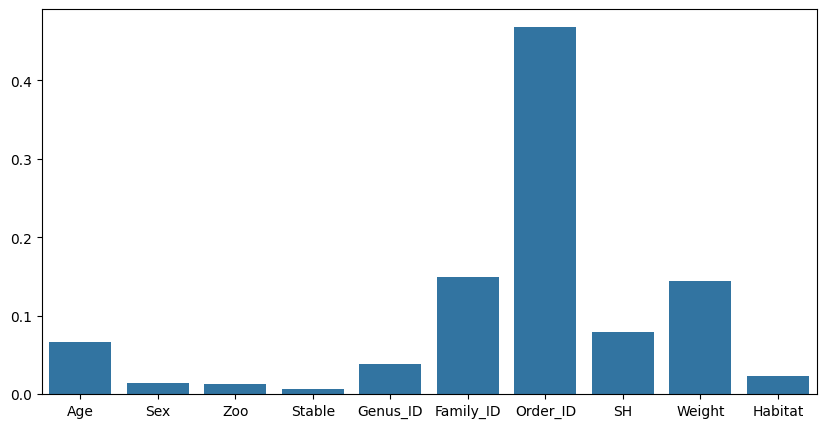

In [254]:
plt.figure(figsize=(10, 5))
sns.barplot(feature_importances)

In [21]:
...

Ellipsis